# Set up

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import nibabel as nib
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
from adjustText import adjust_text
from matplotlib.patches import Ellipse
import re
import os

In [73]:
random.seed(42)
np.random.seed(42)

In [74]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

weights_dir = '/Users/baileyng/MIND_models/models_plsregression/PLS_weights'

# PLS Analysis Function

In [75]:
# inner parallelized
def pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            PLSRegression()
        )

        param_grid = {
            'plsregression__n_components': list(range(1, 11))
        }

        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error',  # or 'r2'
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        best_n = grid.best_params_['plsregression__n_components']
        best_ncomps.append(best_n)
        
        y_pred = grid.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- extract loadings and compute VIP ---
        pls = grid.best_estimator_.named_steps['plsregression']
        coefs_list.append(pls.coef_.ravel())
        
        T = pls.x_scores_
        W = pls.x_weights_
        Q = pls.y_loadings_
        p, h = W.shape

        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
            f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
        f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

    # Get feature names after preprocessing
    # First, fit the preprocessor to get the transformed feature names
    preprocessor_fitted = preprocessor.fit(X)

    # Get feature names for each transformer
    num_features = continuous_vars
    cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # Combine all feature names in the correct order
    all_feature_names = num_features + cat_features


    # Final refit on all data
    final_pipe = make_pipeline(
        preprocessor,
        PLSRegression(
            n_components=int(np.round(np.mean(best_ncomps))),
        )
    ).fit(X, y)

    pls = final_pipe.named_steps['plsregression']
    ct  = final_pipe.named_steps['columntransformer']

    W = pls.x_weights_

    weights_dir = weights_dir
    os.makedirs(weights_dir, exist_ok=True)

    #Create a DataFrame to store the weights
    weights_df = pd.DataFrame(W, 
                              index=all_feature_names, 
                              columns=[f'Component_{i+1}' for i in range(W.shape[1])])

    weights_filename = f'PLS_weights_{data_name}_{target_name}.csv'
    weights_filepath = os.path.join(weights_dir, weights_filename)
    weights_df.to_csv(weights_filepath)

    print(f"PLS weights saved to: {weights_filepath}")

    with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
        MIND_regions = [line.strip() for line in f.readlines()]

    # Create edge lists for each component
    edge_list1 = []
    edge_list2 = []
    edge_list3 = []

    for i, feature_name in enumerate(all_feature_names):
        if feature_name in MIND_regions:
            regions = feature_name.split('-')
            region1, region2 = regions

            edge_list1.append((region1, region2, W[i, 0]))
            edge_list2.append((region1, region2, W[i, 1]))
            edge_list3.append((region1, region2, W[i, 2]))

    #FreeSurfer centroids.txt 
    def parse_freesurfer_centroids(centroids_path):
        region_to_coord = {}
        with open(centroids_path, 'r') as f:
            for line in f:
                if line.startswith('#') or line.strip() == "":
                    continue
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                label = parts[1]
                coords = tuple(map(float, parts[2:5]))
                # Convert 'ctx-lh-bankssts' -> 'lh_bankssts'
                match = re.match(r'ctx-(lh|rh)-(.*)', label)
                if match:
                    hemi, region = match.groups()
                    key = f"{hemi}_{region}"
                    region_to_coord[key] = coords
        return region_to_coord

    centroids_file = '/Users/baileyng/MIND_models/centroids.txt'
    region_to_coord = parse_freesurfer_centroids(centroids_file)
    
    edge_lists = [edge_list1, edge_list2, edge_list3]
    component_names = ['PLS1', 'PLS2', 'PLS3']

    for comp_idx, (edge_list, comp_name) in enumerate(zip(edge_lists, component_names)):
        # Sort edges by magnitude and take top edges
        edge_list_sorted = sorted(edge_list, key=lambda x: abs(x[2]), reverse=True)
        top_n = 50
        top_edges = edge_list_sorted[:top_n]
        
        # Getting list of nodes and coordinates  
        node_labels = sorted({n for edge in top_edges for n in edge[:2]})
        coords_native = []
        missing = []
        for label in node_labels:
            if label in region_to_coord:
                coords_native.append(region_to_coord[label])
            else:
                coords_native.append((float('nan'), float('nan'), float('nan')))
                missing.append(label)
        coords_native = np.array(coords_native)
        label_to_idx = {lab: i for i, lab in enumerate(node_labels)}
        n_nodes = len(node_labels)

        if missing:
            print(f"WARNING: The following regions were not found in centroids.txt for {comp_name}:")
            print(missing)

        # Transform coordinates to MNI space  
        def load_talairach_xfm(xfm_path):
            with open(xfm_path) as f:
                lines = f.readlines()
            start = [i for i, l in enumerate(lines) if 'Linear_Transform' in l][0]
            matrix_lines = lines[start+1:start+4]
            matrix = np.array([
                [float(val.strip(';')) for val in line.strip().split()]
                for line in matrix_lines
            ])
            affine = np.eye(4)
            affine[:3, :4] = matrix
            return affine

        talairach_xfm = '/Applications/freesurfer/subjects/bert/mri/transforms/talairach.xfm'
        affine = load_talairach_xfm(talairach_xfm)
        coords_mni = nib.affines.apply_affine(affine, coords_native)

        # Create adjacency matrix
        adj_matrix = np.zeros((n_nodes, n_nodes))
        for n1, n2, w in top_edges:
            i, j = label_to_idx[n1], label_to_idx[n2]
            adj_matrix[i, j] = w
            adj_matrix[j, i] = w  # For undirected connectome

        # Scale coordinates
        def scale_coords_to_brain(coords, scale=1.0):
            mean = np.mean(coords, axis=0)
            coords_centered = coords - mean
            coords_scaled = coords_centered * scale
            coords_scaled = coords_scaled + mean
            return coords_scaled

        coords_mni_scaled = scale_coords_to_brain(coords_mni, scale=1.0)

        # Calculate symmetric limits for colorbar
        max_abs_val = np.max(np.abs(adj_matrix))
        
        print(f"{comp_name}: Top edge weight magnitude: {max_abs_val:.4f}")

        # Plot  
        fig = plt.figure(figsize=(12, 8))

        display = plotting.plot_connectome(
            adj_matrix,
            coords_mni_scaled,
            edge_threshold=0.0,
            node_color='black',
            node_size=50,
            display_mode='ortho',
            title=f"Top {top_n} Edges - {comp_name} (MIND)",
            figure=fig,
            edge_cmap='bwr',
            edge_vmin=-max_abs_val,
            edge_vmax=max_abs_val,
            node_kwargs={'alpha': 0.9}
        )

        sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-max_abs_val, vmax=max_abs_val))
        sm.set_array([])
        cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
        cb = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cb.set_label('Edge Weight (Red = Positive, Blue = Negative)', fontsize=14, labelpad=10)
        cb.ax.tick_params(labelsize=12)

        plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar
        plt.show()

    

# GF

In [76]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_GF_no_outliers.csv', index_col=0)
target_name = 'GF'

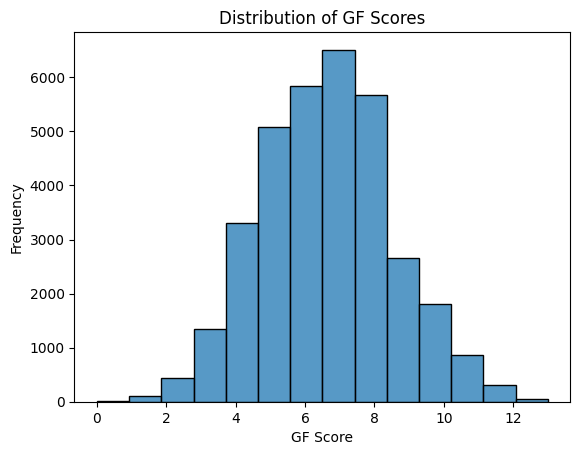

In [77]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'], bins=14)
plt.title('Distribution of GF Scores')
plt.xlabel('GF Score')
plt.ylabel('Frequency')
plt.show()

In [78]:
print(len(df))
print(df.shape)

33977
(33977, 2628)


## GF vs. MIND

In [79]:
data_name = 'MIND'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 2281)
(33977,)


In [80]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [ ]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

TypeError: pls_analysis() missing 3 required positional arguments: 'weights_dir', 'data_name', and 'target_name'

# PAL

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_PAL_no_outliers.csv', index_col=0)
target_name = 'PAL'

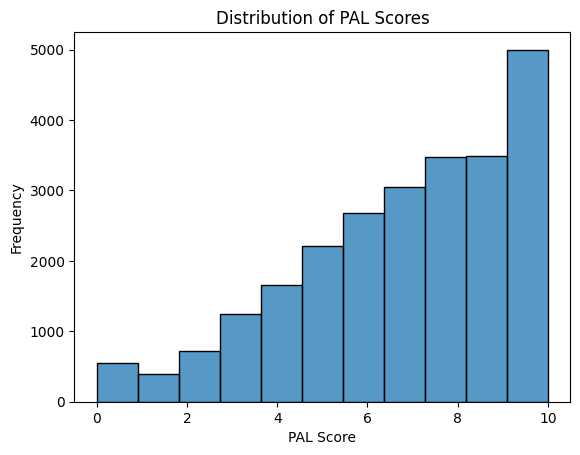

In [ ]:
# Histogram of PAL Scores
sns.histplot(df['20197-2.0'], bins=11)
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### PAL vs. MIND

In [ ]:
data_name = 'MIND'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 2281)
(24492,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

Fold 01 • n_comp=03 • MAE=2.120 • RMSE=2.579 • R²=0.035
Fold 02 • n_comp=03 • MAE=2.111 • RMSE=2.562 • R²=0.043
Fold 03 • n_comp=03 • MAE=2.116 • RMSE=2.585 • R²=0.031

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  2.116 ± 0.004
RMSE:  2.575 ± 0.010
R²  :  0.036 ± 0.005
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_PAL.csv
PLS1: Top edge weight magnitude: 0.0714


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_2485/384342789.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


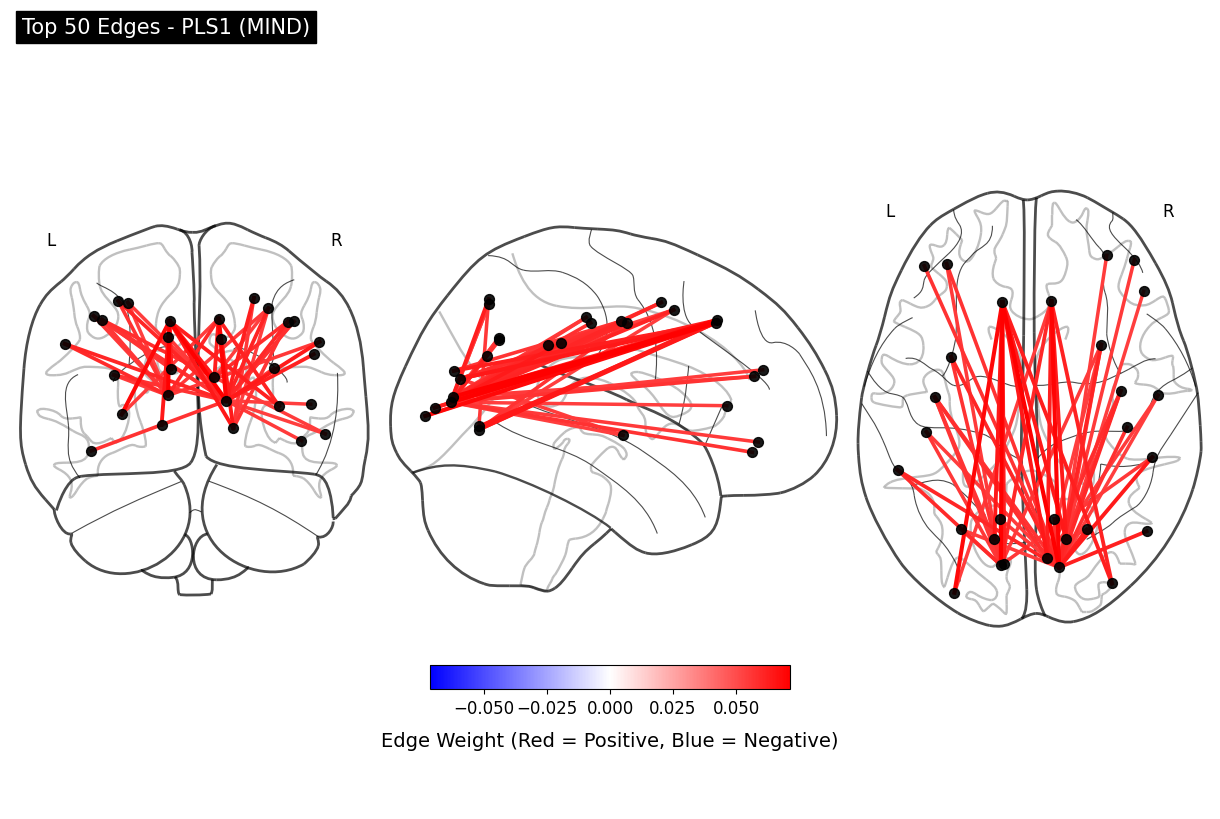

PLS2: Top edge weight magnitude: 0.0587


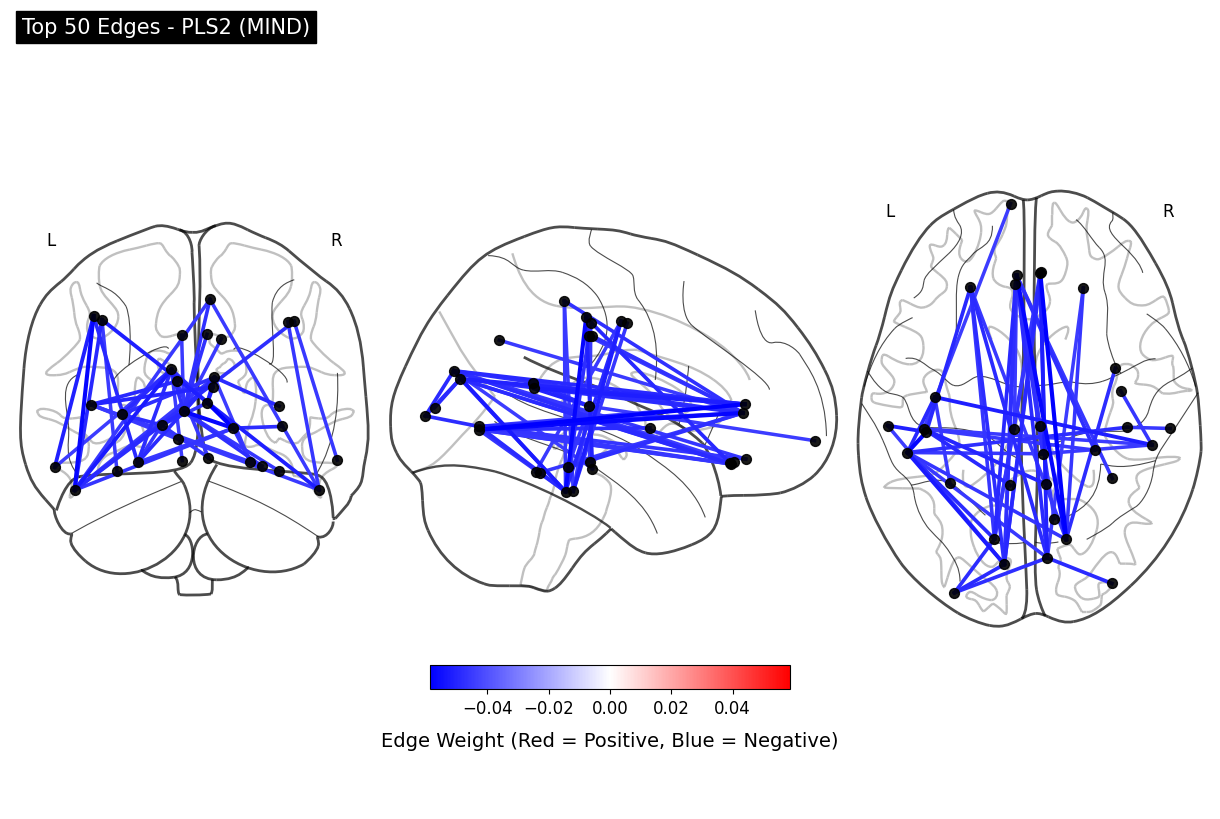

PLS3: Top edge weight magnitude: 0.0565


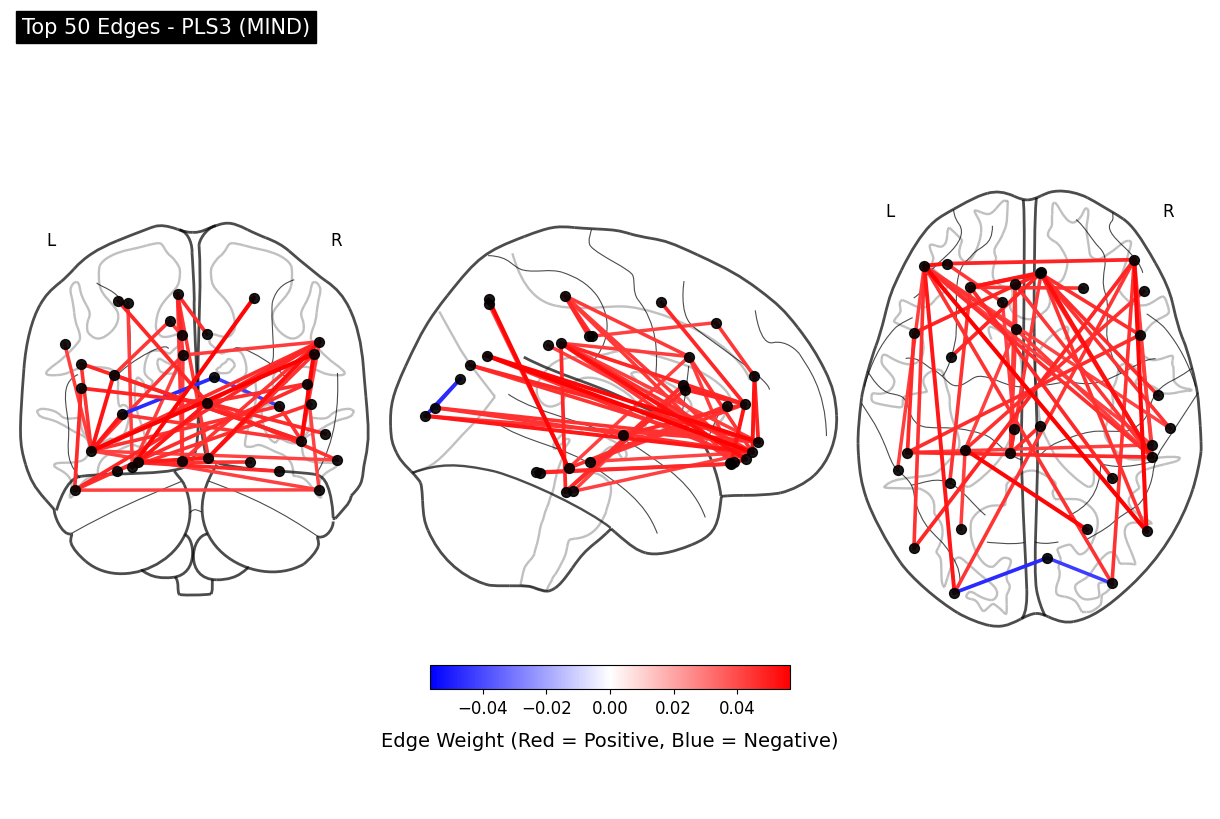

In [ ]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

# DSST

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_DSST_no_outliers.csv', index_col=0)
target_name = 'DSST'

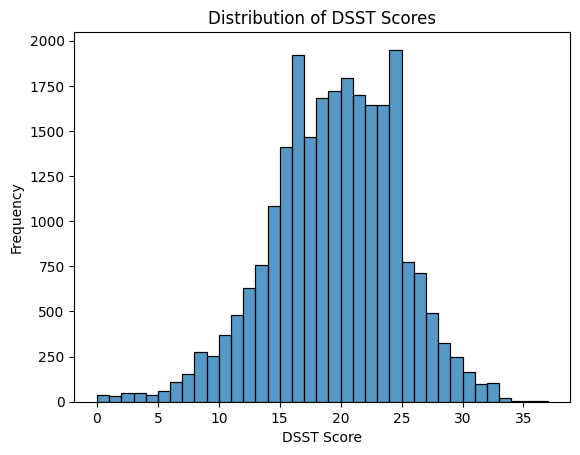

In [ ]:
# Histogram of DSST Scores
sns.histplot(df['23324-2.0'], bins=37)
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(len(df))
print(df.shape)

24275
(24275, 2628)


### DSST vs. MIND

In [ ]:
data_name = 'MIND'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 2281)
(24275,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [ ]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=10 • MAE=3.764 • RMSE=4.769 • R²=0.173
Fold 02 • n_comp=10 • MAE=3.865 • RMSE=4.909 • R²=0.186
Fold 03 • n_comp=10 • MAE=3.760 • RMSE=4.766 • R²=0.181
Fold 04 • n_comp=10 • MAE=3.686 • RMSE=4.673 • R²=0.141
Fold 05 • n_comp=10 • MAE=3.821 • RMSE=4.863 • R²=0.165


KeyboardInterrupt: 

# TMT

In [ ]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_TMT_no_outliers.csv', index_col=0)
target_name = 'TMT'

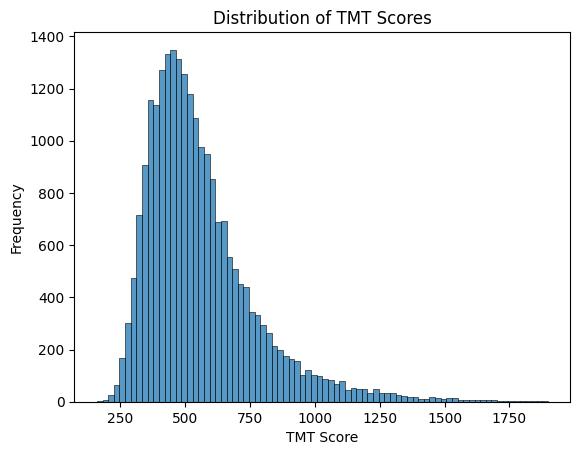

In [ ]:
# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'], bins=80)
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(len(df))
print(df.shape)

23362
(23362, 2628)


### TMT vs. MIND

In [ ]:
data_name = 'MIND'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 2281)
(23362,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [ ]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=10 • MAE=154.170 • RMSE=207.349 • R²=0.075
Fold 02 • n_comp=10 • MAE=144.555 • RMSE=192.138 • R²=0.125
Fold 03 • n_comp=10 • MAE=146.401 • RMSE=198.617 • R²=0.111
Fold 04 • n_comp=10 • MAE=143.089 • RMSE=197.674 • R²=0.131
Fold 05 • n_comp=10 • MAE=143.380 • RMSE=193.257 • R²=0.110
Fold 06 • n_comp=10 • MAE=145.262 • RMSE=202.085 • R²=0.117
Fold 07 • n_comp=10 • MAE=146.335 • RMSE=197.612 • R²=0.115
Fold 08 • n_comp=10 • MAE=148.679 • RMSE=205.495 • R²=0.130
Fold 09 • n_comp=10 • MAE=150.024 • RMSE=206.563 • R²=0.100
Fold 10 • n_comp=10 • MAE=147.616 • RMSE=202.686 • R²=0.149

=== 10-fold CV summary ===
n_components (mean ± std): 10.0 ± 0.0
MAE :  146.951 ± 3.193
RMSE:  200.348 ± 5.079
R²  :  0.116 ± 0.019
